# YouTube Virality Predictor
## Reverse Engineering the YouTube Algorithm to predict the probability of video going viral based on the category and title.

In [2]:
import os
import numpy as np
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors

import pickle
import joblib

from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preprocessing

In [3]:
def generateCategoryDict():
    # Creating a dictionary mapping of category ID -> category title
    
    # Read in JSON file of categories
    categoriesJson = pd.read_json('input/US_category_id.json')
    # Parse items object that contains all the categories
    categoriesJson = categoriesJson['items']
    # Dictionary being created
    categories = {}
    
    # Populate dict of categories
    for item in categoriesJson:
        categories[item['id']] = item['snippet']['title']
    return categories

def preprocessing():
    global df
    # Visualize disparities
    fig = plt.figure(figsize=(8,6))
    df.groupby('category_id').category_id.count().plot.bar(ylim=0)
    plt.title('Visualize category feature disparity')
    plt.show()
    
    # Preprocess Data
    global X_train, X_test, y_train, y_test
    
    # Preforming Dimensionality Reduction to Feature Set
    df = df[['title', 'category_id', 'views']]
    # Features used: title, category_id
    X = df[['title', 'category_id']]
    y = df[['views']]

    # Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    

stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

### Training on X_train and y_train
#### Applying Model Selection

In [4]:
vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

def trainModel(X_train, X_test, y_train, y_test):
    global clf
    # Train Models on training data
    
    # Model 1: TF-IDF as a feature for K-NN
#     print(cosine_sim('a little bird', 'the little bird'))
    
    #Vectorize (TF-IDF, ngrams 1-4, no stop words) using sklearn -->
#     vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,4),
#                      min_df = 0, stop_words = 'english')

    
#     X_train['title'] = vectorizer.fit_transform(X_train['title'])

#     print(X_test['title'][0:10])
#     X_test['title'] = vectorizer.fit_transform(X_test['title'])
#     print(( X_test['title'][0:10]))
    
#     clf = neighbors.KNeighborsRegressor(n_neighbors=1)
#     clf.fit(X_train, y_train)
#     print(clf.score(X_test, y_test))


    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train['title'])
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    
    clf = MultinomialNB().fit(X_train_tfidf, y_train['views'])

#     model_performance = clf.score(X_test['title'], y_test['views'])
#     print(model_performance)
    
    
    # Model 2: K-NN
#     scaler = MinMaxScaler(feature_range=(0, 1))

#     x_train_scaled = scaler.fit_transform(X_train)
#     X_train = pd.DataFrame(x_train_scaled)

#     x_test_scaled = scaler.fit_transform(X_test)
#     X_test = pd.DataFrame(x_test_scaled)

def trainModelPROD():
    global clf
    

    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train['title'])
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    # clf = LinearSVC().fit(X_train_tfidf, y_train['views'])
    # clf = LogisticRegression(random_state=0).fit(X_train_tfidf, y_train['views'])


    clf = MultinomialNB()

    # 1000 data points - underfitted
    # 5000 data points - moderately underfitted
    clf.fit(X_train_tfidf[0:5000], y_train['views'][0:5000])
    print(clf)
    return count_vect

### Read in Youtube US Video CSV
#### Create dataframe

In [5]:
X_train, X_test, y_train, y_test = None, None, None, None
df = pd.read_csv('input/USvideos.csv')
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


# Main Function Calls

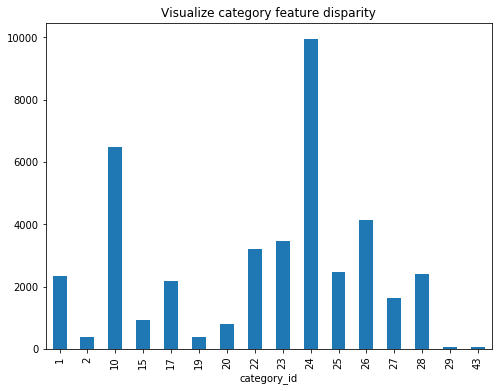

In [6]:
#########################
#    Preprocess Call    #
#########################

generateCategoryDict()
preprocessing()

In [7]:
####################
#    Train Call    #
####################

clf = None
# trainModel(X_train, X_test, y_train, y_test)
count_vect = trainModelPROD()

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [8]:
########################
#    Example Impact    #
########################

# print(clf.predict(count_vect.transform(["top 10 ways to get rich"]))[0], "Predicted Views on YouTube")
# print(clf.predict(count_vect.transform(["how to get rich"]))[0], "Predicted Views on YouTube")

# print(clf.predict(count_vect.transform(["How to profit with coding"]))[0], "Predicted Views on YouTube")
# print(clf.predict(count_vect.transform(["How to make money with coding"]))[0], "Predicted Views on YouTube")

###############
#    USAGE    #
###############

inputTitle = "hi"

# vocabulary_to_load = pickle.load(open(dictionary_filepath, 'r'))
# loaded_vectorizer = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(ngram_size,
#                                         ngram_size), min_df=1, vocabulary=vocabulary_to_load)
# loaded_vectorizer._validate_vocabulary()

predictedViewCount = clf.predict(count_vect.transform([inputTitle]))[0]

# Readable categories (temp)

if predictedViewCount > 100000000:
    print('Mega Trending')
elif predictedViewCount > 10000000:
    print('Trending')
elif predictedViewCount > 1000000:
    print('Great')
elif predictedViewCount > 500000:
    print('Very Good')
elif predictedViewCount > 100000:
    print('Good')
elif predictedViewCount > 10000:
    print('Decent')
elif predictedViewCount > 1000:
    print('Consider Something Else')

print(predictedViewCount, "Predicted Views on YouTube")

Consider Something Else
3741 Predicted Views on YouTube


In [9]:
def serialize_model(clf, name="YTmodel_pickle"):
    # Creating serialized object
    with open(name, 'wb') as f:
        pickle.dump(clf, f)
        
    with open("count_vect", 'wb') as f:
        pickle.dump(count_vect, f)

def remove_serialized_model(name="YTmodel_pickle"):
    # Removing serialized object
    os.remove(name)
    
serialize_model(clf)